





#   TTC Subway & SRT Train Service Delays 2016 - 2019
##  Two categories of delays 


## 1. Summary


The goal of this project to explore TTC Subway & SRT Train Service Delay Data to forecast duration by category of possible service delays in relation to weekday, time, TTC line, and other data.

The minimum delay time which is considered in the project is 15 minutes. There are two options are available for defining of ranges of time delays. Three or two ranges could be set to get more consistent data sets with a smaller number of outliers.  

In the project, two ranges of time delays are defined: 15-60 minutes and 60 minutes or more. They were selected based on personal schedule requirements. 
Selection of project setting including time periods can be changed with some light rework of the script. 

Stations are not used in for a model building, because there are many variations and typos in the station names. Some of them are not associated with any station name from TTC station list, other represent part of TTC line. Creation sets of stations based on information  about a line and a bound looks quite artifitial and could not be relaible without additional verification. 

Time length between trains ('Min Gap' variable) is similar with delay to subway service  ('Min Delay'  variable) and relates to other stations in bound on the line. Only 'Min Delay'  variable is taken into account in the prediction.



## 2. Data Set


TTC Subway & SRT Train Service Delay Data from City of Toronto Open Data portal https://open.toronto.ca/dataset/ttc-subway-delay-data/ contains .xlsx files with delays data by month.  

There are 10 variables in the data set:

<b>Date</b> - Date in YYYY/MM/DD format  
<b>Time</b> - Time in HH:MM format  
<b>Day</b> - Name of the day of the week  
<b>Station</b> - TTC subway station name  
<b>Code</b> - TTC delay code  
<b>Bound</b> - Direction of train dependant on the line  
<b>Line</b> - TTC subway line i.e. YU, BD, SHP, and SRT  
<b>Vehicle</b> - TTC train number 
<b>Min Delay</b> - Delay (in minutes) to subway service  
<b>Min Gap</b> - Time length (in minutes) between trains 


## 3. Importing Libraries and Data Sets


In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime, timedelta
import statistics as st

# Customizing Matplotlib with style sheets and rcParams 
plt.style.use('seaborn-white')

params = {'figure.titlesize': 15, 'axes.titlesize': 14, 'axes.labelsize': 12}
plt.rcParams.update(params)

########################### Load TTC delay data files ###############################

# Load the .xlsx files contain TTC delay data from the 'delays_by_month' folder
# Print the list of file names, dimensions of DataFrames
print('Original Data:')
print('Datatsets:')

files=[]
for f in os.listdir('1. Original Data/delays_by_month'):
    if f.endswith('.xlsx'):
        df_f = pd.read_excel('1. Original Data/delays_by_month/' + f)
        # Print file names and dimensionality of the DataFrames
        print(f, df_f.shape) 
        files.append(df_f)

# Concatenate DataFrames to combine the data       
df_data = pd.concat(files)
print('\nСombined Data Set:', df_data.shape)
print(len(files),'files downloaded')


############### Load files with additional information (TTC delay codes) ################

# Load the .xls file with codes of delays
ttc_codes = '1. Original Data/ttc_data/Subway & SRT Log Codes.xls'
codes = pd.read_excel(ttc_codes)

# Transform two tables from 'Subway & SRT Log Codes.xls' file into a dataframe to combine all codes 
# Create two separate dataframes for SUB RMENU codes and SRT RMENU codes
codes_SUB = pd.DataFrame(codes[['SUB RMENU CODE', 'CODE DESCRIPTION']])
codes_SRT = pd.DataFrame(codes[['SRT RMENU CODE', 'CODE DESCRIPTION.1']])

# Drop empty rows created by Python from xls file. 
codes_SUB.dropna(inplace=True)
codes_SRT.dropna(inplace=True)

# Rename columns in both dataframes to 'Code' and 'Reason for delay'
codes_SUB.rename(columns={'SUB RMENU CODE':'Code', 'CODE DESCRIPTION':'Reason for delay'}, inplace=True)
codes_SRT.rename(columns={'SRT RMENU CODE':'Code', 'CODE DESCRIPTION.1':'Reason for delay'}, inplace=True)

# Concat two dataframes with codes into one 
codes_conc = pd.concat([codes_SUB,codes_SRT])

# Merging sabway delas data with code descriptions 
df = pd.merge(df_data, codes_conc, on='Code', how='left')

############################## Functions ###############################

def mask_outliers (dataframe, column):
    """ Returns mask for outliers in the spesific column. """
    series = dataframe[column]
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    #Interquartile range
    iqr = q3-q1 
    low  = q1-1.5*iqr
    high = q3+1.5*iqr
    filter_out = (series < low) | (series > high)
    return filter_out

def filter_outliers (dataframe, column):
    """ Returns dataframe with outliers in the spesific column. """
    series = dataframe[column]
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    #Interquartile range
    iqr = q3-q1 
    low  = q1-1.5*iqr
    high = q3+1.5*iqr
    filter_out = (series < low) | (series > high)
    data_out = dataframe.loc[filter_out]
    return data_out, low, high

def print_outliers_info(dataframe, column):
    """ Print outliers' info. """
    data_out, low, high = filter_outliers (dataframe, column)
    dt = data_out[column]
    print(f'Outliers: < than {low} or > than {high}')
    print(f'# of outliers: {dt.count()}')
    print(f'Outliers: {list(dt.sort_values().unique())}')
    print(f'Outliers: Median: {dt.median()}, Mean: {dt.mean()}')

Original Data:
Datatsets:
subway-srt-logs-august-2019.xlsx (1630, 10)
subway-srt-logs-july-2019.xlsx (1696, 10)
subway-srt-logs-october-2019.xlsx (1497, 10)
subway-srt-logs-september-2019.xlsx (1531, 10)
ttc-subway-delay-april-2018.xlsx (1597, 10)
ttc-subway-delay-april-2019.xlsx (1550, 10)
ttc-subway-delay-august-2017.xlsx (1581, 10)
ttc-subway-delay-august-2018.xlsx (1937, 10)
ttc-subway-delay-december-2017.xlsx (1881, 10)
ttc-subway-delay-december-2018.xlsx (1465, 10)
ttc-subway-delay-february-2018.xlsx (1470, 10)
ttc-subway-delay-february-2019.xlsx (1598, 10)
ttc-subway-delay-jan-2014-april-2017.xlsx (69016, 10)
ttc-subway-delay-january-2018.xlsx (1873, 10)
ttc-subway-delay-january-2019.xlsx (1871, 10)
ttc-subway-delay-july-2017.xlsx (1497, 10)
ttc-subway-delay-july-2018.xlsx (1885, 10)
ttc-subway-delay-june-2017.xlsx (1568, 10)
ttc-subway-delay-june-2018.xlsx (1794, 10)
ttc-subway-delay-june-2019.xlsx (1604, 10)
ttc-subway-delay-march-2018.xlsx (1621, 10)
ttc-subway-delay-march-20

In [2]:
df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Reason for delay
0,2019-08-01,00:05,Thursday,YONGE UNIVERSITY LINE,MUGD,0,0,NaN,YU,0,Miscellaneous General Delays
1,2019-08-01,00:06,Thursday,NORTH YORK CTR STATION,EUSC,0,0,S,YU,5841,Speed Control Equipment
2,2019-08-01,01:30,Thursday,DUFFERIN STATION,SUO,0,0,NaN,BD,0,Passenger Other
3,2019-08-01,01:34,Thursday,VAUGHAN MC STATION,SUDP,0,0,NaN,YU,0,Disorderly Patron
4,2019-08-01,01:42,Thursday,BLOOR STATION,MUIRS,0,0,S,YU,0,Injured or ill Customer (In Station) - Medical...



## 4. Setting the Data Requirements for the Project


In [3]:
##############################  Set data requirements for the project  #####################################

# Set minimum delay time, time, dates which will be considered in the project
time_delay = 15 # Delays 15 minutes and more

# Set time range
start_time_project = '06:00' 
start_date_project = '2016-10-01'  

end_time_project = '23:59' 
end_date_project = '2019-11-01' 

outliers_very_long_delays = 7 # A max number of 30 minutes units for too long delays.  
                              #Longer delays will be replaced by median for that type of delays  

#                                  AND
#
# Create two or three ranges of time delays in the 'Bin' section below  to get more consistent data sets: 
#        15-60 minutes and 60 minutes or more
#                                  OR
#        15-30 minutes, 30-60 minutes, and 60 minutes or more
 
    
############################################################################################################
print('Project settings:')
print(f'Minimum delay time: {time_delay} minutes')

# Filter the relevant data
# Filter the data by delay time
filt_delays = (df['Min Delay'] >= time_delay)
data = df[filt_delays]

# Filter the data by date
# Convert dates into datetime objects
start_date = pd.to_datetime(start_date_project)
end_date = pd.to_datetime(end_date_project)
# Filter the data
filt_dates = ((data['Date']>=start_date) & (data['Date']<end_date))
data = data[filt_dates]

date_min = data['Date'].min()
date_max = data['Date'].max()
print(f'Dates: {date_min} - {date_max}')

# Filter the data within specific time range
# Convert dates into datetime objects
start_time = pd.to_datetime(start_time_project)
end_time = pd.to_datetime(end_time_project)

# Convert time from string format to datetime object 
data['Time_CurrentDate']=pd.to_datetime(data['Time'])
# Filter the data
filt_time = ((data['Time_CurrentDate']>=start_time) & (data['Time_CurrentDate']<=end_time))
data = data[filt_time]

time_min = data['Time_CurrentDate'].min()
time_max = data['Time_CurrentDate'].max()
print(f'Time: {time_min} - {time_max}')

# Drop the 'Time_CurrentDate' column
data.drop('Time_CurrentDate', inplace=True, axis=1)

# Reset index
data = data.reset_index(drop=True)

# Drop columns which are not used in the project
drop_columns = ['Code','Min Gap','Vehicle']
data.drop(columns=drop_columns, axis=1, inplace=True)

# Check duplicated rows
print('Duplicated rows: ', data.duplicated().sum())

# Save duplicates rows to the 'Analysis' folder
duplicated_rows = data[data.duplicated()].sort_values(by='Date')
duplicated_rows.to_excel("2. Analysis/ttc_2_ranges_duplicated_rows.xlsx")

# Drop duplicated rows
data.drop_duplicates(inplace=True)
data.duplicated().sum()
print('Duplicated rows are dropped.')
print('Duplicated rows: ', data.duplicated().sum())

# Reset index
data.reset_index(drop=True, inplace=True)

print('\nOriginal Data Set:', df.shape)
print('Data Set for Project:', data.shape)

Project settings:
Minimum delay time: 15 minutes
Dates: 2016-10-02 00:00:00 - 2019-10-30 00:00:00
Time: 2020-04-29 06:00:00 - 2020-04-29 23:58:00
Duplicated rows:  4
Duplicated rows are dropped.
Duplicated rows:  0

Original Data Set: (118867, 11)
Data Set for Project: (1025, 8)


## 5. Data Exploration

In [4]:
# Print a summary of the DataFrame 
# Get column dtypes, non-null values
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1025 non-null   datetime64[ns]
 1   Time              1025 non-null   object        
 2   Day               1025 non-null   object        
 3   Station           1025 non-null   object        
 4   Min Delay         1025 non-null   int64         
 5   Bound             1022 non-null   object        
 6   Line              1025 non-null   object        
 7   Reason for delay  1015 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 64.2+ KB
None


In [5]:
data['Min Delay'].describe()

count    1025.000000
mean       35.100488
std        43.335882
min        15.000000
25%        17.000000
50%        20.000000
75%        32.000000
max       515.000000
Name: Min Delay, dtype: float64

Text(0, 0.5, 'Total Delays')

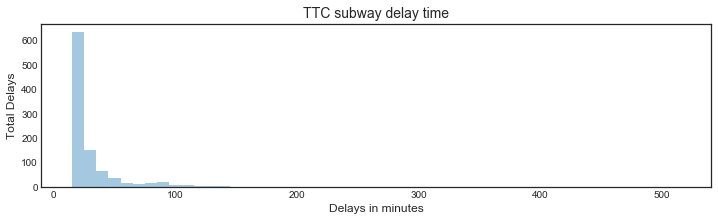

In [6]:
# Common plot settings
delays_title = 'TTC subway delay time'
delays_xlabel = 'Delays in minutes'
delays_ylabel = 'Total Delays'

# Plot the distribution of delays in minutes
fig, ax = plt.subplots(figsize=(12,3))
sns.distplot(data['Min Delay'],bins=50, kde=False, ax=ax)
ax.set_title(delays_title)
ax.set_xlabel(delays_xlabel)
ax.set_ylabel(delays_ylabel)

In [7]:
# Outliers
print_outliers_info(data, 'Min Delay')

Outliers: < than -5.5 or > than 54.5
# of outliers: 132
Outliers: [55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 75, 76, 77, 78, 79, 81, 82, 83, 85, 87, 88, 89, 90, 91, 93, 94, 95, 97, 98, 102, 103, 104, 105, 107, 108, 109, 111, 112, 113, 118, 120, 121, 123, 126, 130, 131, 135, 136, 140, 141, 142, 148, 156, 157, 163, 165, 168, 174, 180, 181, 188, 193, 195, 222, 228, 238, 248, 250, 267, 269, 284, 325, 355, 399, 455, 515]
Outliers: Median: 93.0, Mean: 119.03030303030303


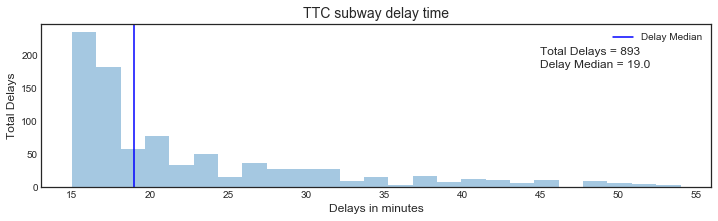

In [8]:
filter_out = mask_outliers(data, 'Min Delay')

# Plot the distribution of delays in minutes without outliers


df_data_out = data[~filter_out]
median = df_data_out['Min Delay'].median()
median_label = f'Delay Median = {median}'
total = df_data_out['Min Delay'].count()
total_label = f'Total Delays = {total}'

fig, ax = plt.subplots(figsize=(12,3))
sns.distplot(df_data_out['Min Delay'],bins=25, kde=False, ax=ax)
ax.axvline(median, color='b', label='Delay Median')
ax.set_title(delays_title)
ax.set_xlabel(delays_xlabel)
ax.set_ylabel(delays_ylabel)
ax.text(45,200, total_label, fontsize=12)
ax.text(45,180, median_label, fontsize=12)
ax.legend()

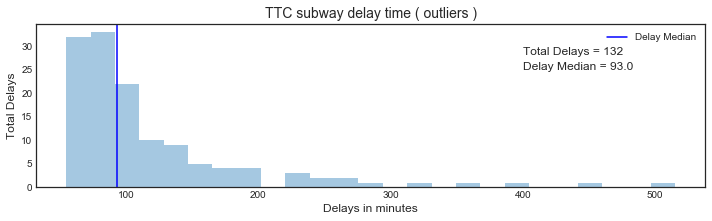

In [9]:
# Plot the distribution of delays in minutes ( outliers )

df_data_out = data[filter_out]
median = df_data_out['Min Delay'].median()
median_label = f'Delay Median = {median}'
total = df_data_out['Min Delay'].count()
total_label = f'Total Delays = {total}'

fig, ax = plt.subplots(figsize=(12,3))
sns.distplot(df_data_out['Min Delay'],bins=25, kde=False,ax=ax)

ax.axvline(median, color='b', label='Delay Median')
ax.set_title(delays_title + ' ( outliers )')
ax.set_xlabel(delays_xlabel)
ax.set_ylabel(delays_ylabel)
ax.text(400,28, total_label, fontsize=12)
ax.text(400,25, median_label, fontsize=12)
ax.legend()



In [10]:
print_outliers_info(df_data_out, 'Min Delay')

Outliers: < than -5.625 or > than 211.375
# of outliers: 13
Outliers: [222, 228, 238, 248, 250, 267, 269, 284, 325, 355, 399, 455, 515]
Outliers: Median: 269.0, Mean: 311.9230769230769


In [11]:
# Check missing data
# Sum missing data by column and arrange in descending order
total = data.isnull().sum().sort_values(ascending=False)
# Get corresponding percentage of missing values
percent = ((data.isnull().sum()/data.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent],axis=1,keys=['Total','Percentage'])
# Print summary of missing data
print(f'\nMissing data: \n {missing_data.head(3)}')


Missing data: 
                   Total  Percentage
Reason for delay     10    0.975610
Bound                 3    0.292683
Line                  0    0.000000


'Reason for delay' and 'Bound'  features contain missing values around 1% and 0.3% respectively.  
'Reason for delay' will be used only for additional information, and will be dropped later.
'Bound' will be handled in categorical data section.

The distribution of TTC subway delay time is positively skewed. There are many outliers in the data set. Creation of two ranges of time delays: 15-60 minutes and 60 minutes or more helps to get more consistent data sets with a smaller number of outliers.

In [12]:
################################################# Bins  ##########################################################

#################### ------------------ The first option
# Create three ranges of time delays: 15-30 minutes, 30-60 minutes, and 60 minutes or more to get more consistent data sets
#bins = [15, 30, 60, (data['Min Delay'].max()+1)]

#################### ------------------ The second option
# Create two ranges of time delays: 15-60 minutes and 60 minutes or more to get more consistent data sets
bins = [15, 60, (data['Min Delay'].max()+1)]

###################################################################################################################



print('Bins: ', bins)

data['Delay_Time_Range'] = pd.cut(data['Min Delay'], bins = bins, right=False)
data['Delay_Time_Range'] = data['Delay_Time_Range'].astype(str)

print(data['Delay_Time_Range'].value_counts())

# Create a list of time ranges for hue order on plots and later references
time_ranges_list=data['Delay_Time_Range'].unique().tolist()
print(time_ranges_list) 

# Create three dataframes based on the the time ranges
delays_small = data[(data['Min Delay'] >= bins[0]) & (data['Min Delay'] < bins[1])]
delays_medium = data[(data['Min Delay'] >= bins[1]) & (data['Min Delay'] < bins[2])]
delays_large = data[data['Min Delay'] >= bins[2]]

# Create a list of dataframes for later references
list_df = [delays_small, delays_medium, delays_large]

####################################### Common plot settings #################################################
# Set the titles for axes
title_delays_all=f'Delays of {bins[0]} minutes or more'
title_delays_small=f'Delays of {bins[0]} to {bins[1]} minutes'
title_delays_medium=f'Delays of {bins[1]} to {bins[2]} minutes'
title_delays_large=f'Delays of {bins[2]} minutes or more'

# Set the titles for a legend
title_delays=f' Delays by category,\n in minutes'

# Set the title for plots
delays_title_epl = f'TTC subway delays by '

# Create a list of titles of dataframes for later references
list_title_df = [title_delays_small, title_delays_medium, title_delays_large]

# Legends, ticks for plots
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
hours = ['05:30','06:00','06:30','07:00','07:30','08:00','08:30','09:00','09:30','10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00','14:30','15:00','15:30','16:00','16:30','17:00','17:30','18:00','18:30','19:00','19:30','20:00','20:30','21:00','21:30','22:00','22:30','23:00','23:30','00:00','00:30','01:00','01:30','02:00','02:30','03:00','03:30','04:00','04:30','05:00']

lines = ['1 Yonge-University Line', '2 Bloor-Danforth Line', '3 Scarborough Line', '4 Sheppard Line']

# Get number of months
number_of_months = len(months)

# Spines
sp_color = '#CCCCCC'
sp_linewidth = 1
# Grid
gr_color = '#DDDDDD'

# "Tableau 20" colors as RGB    
colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
          (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
          (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
          (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts    
for i in range(len(colors)):    
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.)   
# Converted RGB colors to Hex colors
color_1='#1F77B4'
color_2='#AEC7E8'
color_3='#FF7F0E'
color_4='#FFBB78'
color_5='#2CA02C'

Bins:  [15, 60, 516]
[15, 60)     904
[60, 516)    121
Name: Delay_Time_Range, dtype: int64
['[15, 60)', '[60, 516)']


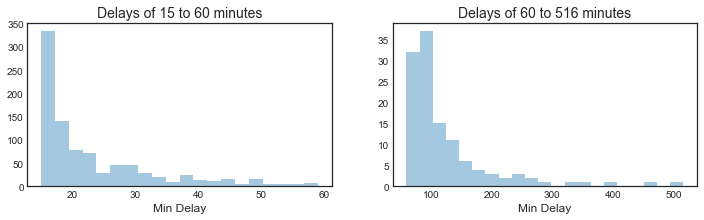

In [13]:
if len(bins)==4:
    # Plot the distribution of the three ranges of time delays 
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
    sns.distplot(delays_small['Min Delay'], kde=False, ax=ax1)
    sns.distplot(delays_medium['Min Delay'], kde=False, ax=ax2)
    sns.distplot(delays_large['Min Delay'], kde=False,  ax=ax3)

    ax1.set_ylabel('')
    ax2.set_ylabel('')
    ax3.set_ylabel('')

    # Add a plot title
    ax1.set_title(title_delays_small)
    ax2.set_title(title_delays_medium)
    ax3.set_title(title_delays_large)
    
elif len(bins)==3:
    # Plot the distribution of the two ranges of time delays 
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
    sns.distplot(delays_small['Min Delay'], kde=False, ax=ax1)
    sns.distplot(delays_medium['Min Delay'], kde=False, ax=ax2)
    
    ax1.set_ylabel('')
    ax2.set_ylabel('')
    
    # Add a plot title
    ax1.set_title(title_delays_small)
    ax2.set_title(title_delays_medium)
    

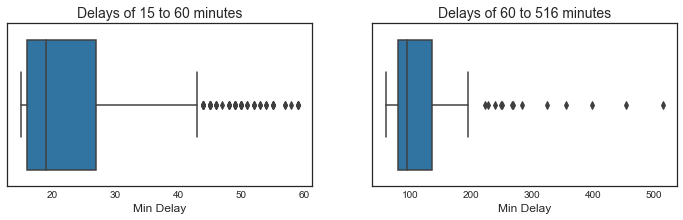

In [14]:
if len(bins)==4:
    # Draw a box plot to show distributions of hree ranges of time delays
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
    sns.boxplot(delays_small['Min Delay'],ax=ax1)
    sns.boxplot(delays_medium['Min Delay'], ax=ax2)
    sns.boxplot(delays_large['Min Delay'], ax=ax3)

    ax1.set_ylabel('')
    ax2.set_ylabel('')
    ax3.set_ylabel('')

    # Add a plot title
    ax1.set_title(title_delays_small)
    ax2.set_title(title_delays_medium)
    ax3.set_title(title_delays_large)

elif len(bins)==3:
    # Draw a box plot to show distributions of two ranges of time delays
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
    sns.boxplot(delays_small['Min Delay'],ax=ax1)
    sns.boxplot(delays_medium['Min Delay'], ax=ax2)
    
    ax1.set_ylabel('')
    ax2.set_ylabel('')
    
    # Add a plot title
    ax1.set_title(title_delays_small)
    ax2.set_title(title_delays_medium)
    

In [15]:
# Categorical variables
station_names=data['Station'].unique().tolist()
print('Unique stations: ', len(station_names))
print('Original TTC stations: ', 75)

Unique stations:  108
Original TTC stations:  75


In [16]:
# Group data in 'Bound' and count number of bounds by line 
bounds = data.groupby(['Line','Bound'])[['Bound']].count()
bounds_sum = bounds.sum()
print(bounds)
print('Total:\n', bounds_sum)

            Bound
Line Bound       
BD   E        199
     W        219
SHP  E          9
     W         24
SRT  E          2
     N         46
     S         53
     W          1
YU   N        236
     S        232
     W          1
Total:
 Bound    1022
dtype: int64


There is a number of incorrect bound-line combinations: BD - N, SRT - E, YU - 5, YU - W.

In [17]:
# Select entries with mismatch between a line and a bound by line
df_BD = data[(data['Line']=='BD') & ~((data['Bound']=='E') | (data['Bound']=='W'))].sort_values(by='Station')
df_SHP = data[(data['Line']=='SHP') & ~((data['Bound']=='E') | (data['Bound']=='W'))].sort_values(by='Station')
df_SRT = data[(data['Line']=='SRT') & ~((data['Bound']=='N') | (data['Bound']=='S'))].sort_values(by='Station')
df_YU = data[(data['Line']=='YU') & ~((data['Bound']=='N') | (data['Bound']=='S'))].sort_values(by='Station')
# Concatenate DataFrames 
df_bounds = pd.concat([df_BD, df_SHP, df_SRT, df_YU])
# Select rows where 'Bound' is not missing
df_bounds = df_bounds[~df_bounds['Bound'].isnull()]
# Save entries with mismatch between a line and a bound to the 'Analysis' folder
df_bounds.to_excel("2. Analysis/ttc_2_ranges_bound_line_missmatch_rows.xlsx")

# Correct a line or a bound
# BD line
# Replace incorrect line 'BD' with 'YU'
BD_to_YU = (data['Line']=='BD') & ((data['Station']=='ST CLAIR WEST STATION') | (data['Station']=='YORKDALE STATION')| (data['Station']=='ST PATRICK STATION'))
data['Line']=data['Line'].mask(BD_to_YU, 'YU')
data['Bound'] = data['Bound'].replace({'R':'E'})

# SRT line
# Replace 'E' >> 'N'
SRT_E_N = (data['Line']=='SRT') & (data['Bound']=='E')
data['Bound']=data['Bound'].mask(SRT_E_N, 'N')
# Replace 'W' >> 'S'
SRT_W_S = (data['Line']=='SRT') & (data['Bound']=='W')
data['Bound']=data['Bound'].mask(SRT_W_S, 'S')
# Replace '66' line >> SRT
data['Line'] = data['Line'].replace({'66': 'SRT'})

# YU line
# Replace '5' >> 'S'
data['Bound'] = data['Bound'].replace({'5':'S'})
# Replace incorrect line 'YU' with 'BD'
YU_to_BD = (data['Line']=='YU') & ((data['Station']=='YONGE BD STATION') | (data['Station']=='KENNEDY BD STATION') )
data['Line']=data['Line'].mask(YU_to_BD, 'BD')


# Check coordination of a line and a bound 
bounds_res = data.groupby(['Line','Bound'])[['Bound']].count()
bounds_res_sum = bounds_res.sum()
print(bounds_res)
print('Total:\n', bounds_res_sum)
print(f'\nCheck: {bounds_sum[0]} = {bounds_res_sum[0]}')

            Bound
Line Bound       
BD   E        199
     W        220
SHP  E          9
     W         24
SRT  N         48
     S         54
YU   N        236
     S        232
Total:
 Bound    1022
dtype: int64

Check: 1022 = 1022


In [18]:
# Check missing values
missing_bounds = data[data['Bound'].isnull()].sort_values(by='Line')
print("Missing 'Bound' values:", len(missing_bounds))
# Save the rows with  missing bound to the 'Analysis' folder
missing_bounds.to_excel("2. Analysis/ttc_2_ranges_missing_bound_rows.xlsx")

# Found mode of 'Bound' by line
mode_bound_BD = data[(data['Line']=='BD')]['Bound'].mode()[0]
mode_bound_SHP = data[(data['Line']=='SHP')]['Bound'].mode()[0]
mode_bound_SRT = data[(data['Line']=='SRT')]['Bound'].mode()[0]
mode_bound_YU = data[(data['Line']=='YU')]['Bound'].mode()[0]
print('\nMode: ')
print(f'BD: {mode_bound_BD}, SHP: {mode_bound_SHP}, SRT: {mode_bound_SRT}, YU: {mode_bound_YU}')

# Fill missing 'Bound' values with mode
bound_BD_null = (data['Line']=='BD') & (data['Bound'].isnull())
data['Bound']=data['Bound'].mask(bound_BD_null, mode_bound_BD)

bound_SHP_null = (data['Line']=='SHP') & (data['Bound'].isnull())
data['Bound']=data['Bound'].mask(bound_SHP_null, mode_bound_SHP)

bound_SRT_null = (data['Line']=='SRT') & (data['Bound'].isnull())
data['Bound']=data['Bound'].mask(bound_SRT_null, mode_bound_SRT)

bound_YU_null = (data['Line']=='YU') & (data['Bound'].isnull())
data['Bound']=data['Bound'].mask(bound_YU_null, mode_bound_YU)

# Check missing values are filled
print(f'\nMissing values:\n{data.isnull().sum()}')

Missing 'Bound' values: 3

Mode: 
BD: W, SHP: W, SRT: S, YU: N

Missing values:
Date                 0
Time                 0
Day                  0
Station              0
Min Delay            0
Bound                0
Line                 0
Reason for delay    10
Delay_Time_Range     0
dtype: int64


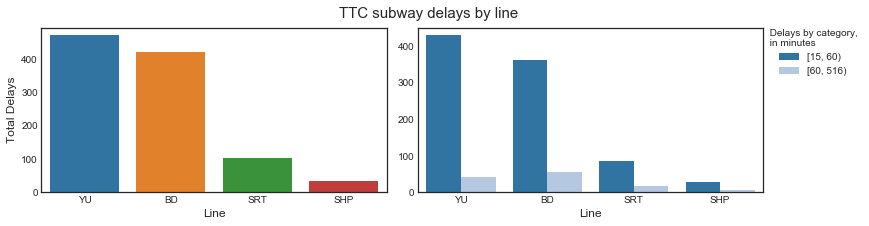

In [19]:

# Plot the counts of observations by line
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
sns.countplot(data['Line'], data=data, ax=ax1)
sns.countplot(data['Line'], data=data, palette=colors, hue='Delay_Time_Range', ax=ax2)

# Add a title to the figure
fig.suptitle(delays_title_epl + 'line',verticalalignment='baseline')

# Set a legend
ax2.legend(bbox_to_anchor=(1.3, 1.05), title=title_delays)

ax1.set_ylabel(delays_ylabel)
ax2.set_ylabel('')

plt.tight_layout()

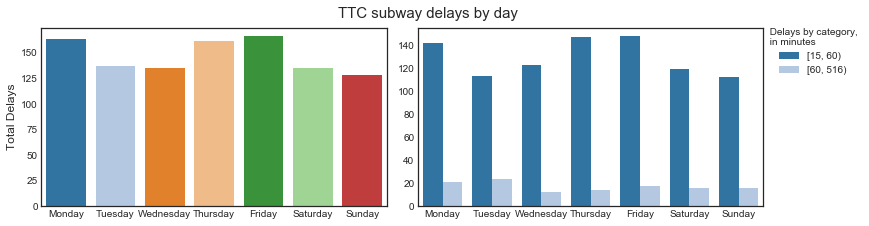

In [20]:
# Plot the counts of observations by weekday
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
sns.countplot(data['Day'], data=data, palette=colors, order=weekdays, ax=ax1)
sns.countplot(data['Day'], data=data, palette=colors, order=weekdays, hue='Delay_Time_Range', ax=ax2)

# Add a title to the figure
fig.suptitle(delays_title_epl + 'day',verticalalignment='baseline')

# Set a legend
ax2.legend(bbox_to_anchor=(1.3, 1.05), title=title_delays)

ax1.set_ylabel(delays_ylabel)
ax2.set_ylabel('')
ax1.set_xlabel('')
ax2.set_xlabel('')

plt.tight_layout()

In [21]:
data['Day'].value_counts()

Friday       166
Monday       163
Thursday     161
Tuesday      137
Wednesday    135
Saturday     135
Sunday       128
Name: Day, dtype: int64

In [22]:
data.head()

,Date,Time,Day,Station,Min Delay,Bound,Line,Reason for delay,Delay_Time_Range
0,2019-08-01,12:12,Thursday,BLOOR STATION,15,S,YU,Unauthorized at Track Level,"[15, 60)"
1,2019-08-01,15:42,Thursday,ST CLAIR STATION,31,N,YU,Injured or ill Customer (On Train) - Transported,"[15, 60)"
2,2019-08-01,15:52,Thursday,OSGOODE STATION,102,S,YU,Priority One - Train in Contact With Person,"[60, 516)"
3,2019-08-06,06:14,Tuesday,ROYAL YORK STATION,19,E,BD,Miscellaneous Speed Control,"[15, 60)"
4,2019-08-06,12:25,Tuesday,DUNDAS WEST STATION,82,W,BD,Priority One - Train in Contact With Person,"[60, 516)"


## 4. Feature Engineering

In [23]:
# Extract month from datetime object
data['Month']=data['Date'].dt.month
# Extract weekday from datetime object
data['Weekday']=data['Date'].dt.weekday

# Count a number of 30 minutes units in a delay time
data['Time_Delta']=(data['Min Delay']/30).round().astype(int)

# Set 1 if unit is 0 as delay time was less than 30 minutes 
data['Time_Delta']=data['Time_Delta'].apply(lambda x: 1 if x==0 else x)

# Round time to 30 minutes 
data['Time_Round_30_min']=pd.to_datetime(data['Time']).dt.round('30min')

# Create lists of time ranges  
data['Range']=data.apply(lambda x: pd.date_range(start=x['Time_Round_30_min'], periods=x['Time_Delta'], freq='30min').time.tolist(), axis=1)
# Copy indexes into the 'Row_Index' column
data['Row_Index']=data.index

data.head()

,Date,Time,Day,Station,Min Delay,Bound,Line,Reason for delay,Delay_Time_Range,Month,Weekday,Time_Delta,Time_Round_30_min,Range,Row_Index
0,2019-08-01,12:12,Thursday,BLOOR STATION,15,S,YU,Unauthorized at Track Level,"[15, 60)",8,3,1,2020-04-29 12:00:00,[12:00:00],0
1,2019-08-01,15:42,Thursday,ST CLAIR STATION,31,N,YU,Injured or ill Customer (On Train) - Transported,"[15, 60)",8,3,1,2020-04-29 15:30:00,[15:30:00],1
2,2019-08-01,15:52,Thursday,OSGOODE STATION,102,S,YU,Priority One - Train in Contact With Person,"[60, 516)",8,3,3,2020-04-29 16:00:00,"[16:00:00, 16:30:00, 17:00:00]",2
3,2019-08-06,06:14,Tuesday,ROYAL YORK STATION,19,E,BD,Miscellaneous Speed Control,"[15, 60)",8,1,1,2020-04-29 06:00:00,[06:00:00],3
4,2019-08-06,12:25,Tuesday,DUNDAS WEST STATION,82,W,BD,Priority One - Train in Contact With Person,"[60, 516)",8,1,3,2020-04-29 12:30:00,"[12:30:00, 13:00:00, 13:30:00]",4


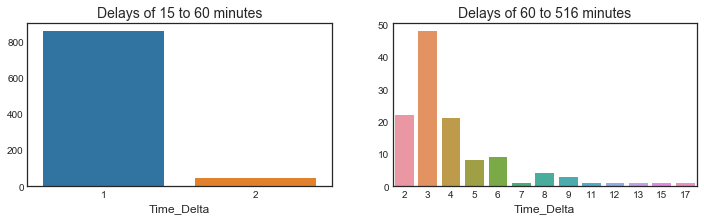

In [24]:

if len(bins)==4:

    # Plot the counts of observations by 30 minutes units ('Time_Delta')
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

    sns.countplot(data[data['Delay_Time_Range']==time_ranges_list[0]]['Time_Delta'], ax=ax1)
    sns.countplot(data[data['Delay_Time_Range']==time_ranges_list[1]]['Time_Delta'], ax=ax2)
    sns.countplot(data[data['Delay_Time_Range']==time_ranges_list[2]]['Time_Delta'], ax=ax3)

    ax1.set_ylabel('')
    ax2.set_ylabel('')
    ax3.set_ylabel('')

    # Add a plot title
    ax1.set_title(title_delays_small)
    ax2.set_title(title_delays_medium)
    ax3.set_title(title_delays_large)

elif len(bins)==3:

    # Plot the counts of observations by 30 minutes units ('Time_Delta')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    sns.countplot(data[data['Delay_Time_Range']==time_ranges_list[0]]['Time_Delta'], ax=ax1)
    sns.countplot(data[data['Delay_Time_Range']==time_ranges_list[1]]['Time_Delta'], ax=ax2)
    #sns.countplot(data[data['Delay_Time_Range']==time_ranges_list[2]]['Time_Delta'], ax=ax3)

    ax1.set_ylabel('')
    ax2.set_ylabel('')
    #ax3.set_ylabel('')

    # Add a plot title
    ax1.set_title(title_delays_small)
    ax2.set_title(title_delays_medium)
    #ax3.set_title(title_delays_large)


In [25]:
import statistics as st
# Print Time ranges, its means and medians
for time_range in time_ranges_list:
    df = data[data['Delay_Time_Range']==time_range]
    time_range_values = df['Time_Delta'].sort_values().unique().tolist()
    mean = st.mean(time_range_values)
    median = st.median(time_range_values)
    
    print('Time range:', time_range)
    print(time_range_values)
    print('Mean:',mean)
    print('Median:',median)
 
 

Time range: [15, 60)
[1, 2]
Mean: 1.5
Median: 1.5
Time range: [60, 516)
[2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 17]
Mean: 8.615384615384615
Median: 8


In [26]:
# Print a list of time ranges
lists = []
for time_range in time_ranges_list:
    df = data[data['Delay_Time_Range']==time_range]['Time_Delta']
    lists.append(df.sort_values().unique().tolist())
print('Time ranges', lists)   

Time ranges [[1, 2], [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 17]]


In [27]:
# Create mask for outlier of very long delays
# outliers_very_long_delays = 7 is the project setting
mask_time_delta = data['Time_Delta'] > outliers_very_long_delays
# Get minimum of 'Time_Delta' for outlier of very long delays
#median_time_delta = data[mask_time_delta]['Time_Delta'].min()
median_time_delta = data[mask_time_delta]['Time_Delta'].median()
# Replace 'Time_Delta' values of very long delay with median
data['Time_Delta'] = data['Time_Delta'].mask(mask_time_delta, median_time_delta)
# Check 'Time_Delta' values
data['Time_Delta'].value_counts()

1    856
2     70
3     48
4     21
9     12
6      9
5      8
7      1
Name: Time_Delta, dtype: int64

In [28]:
def get_time_string(list_time):
    """ Converts a list of datetime.time objects into a list of strings in '%H:%M' format. """
    # Creates a list
    list_time_str=[]
    # Loop through the list 
    for time in list_time:
        # Append a string converted in '%H:%M' format into the list
        list_time_str.append(time.strftime('%H:%M'))
    
    return list_time_str

# Convert lists of datetime.time objects into lists of strings in '%H:%M' format
data['Range_List']=data['Range'].apply(lambda x: get_time_string(x))

# Create DataFrames from lists of time ranges
data['Time_DF'] = data.apply(lambda x: pd.DataFrame(x['Range_List'], index=x['Range_List'], columns=[x['Row_Index']]).transpose(), axis=1)

# Create a DataFrame with  columns equals hours
df_hours=pd.DataFrame(columns=hours)

# Concatenate the DataFrame of hours grid and DataFrames with time ranges
for i in range(0,len(data)):
    df_hours = pd.concat([df_hours,data['Time_DF'][i]], sort=False, axis=0)

print('DataFrame of time ranges:', df_hours.shape)   

DataFrame of time ranges: (1025, 48)


In [29]:
df_hours.tail()

,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,...,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00
1020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Replace non-zero values in the DataFrame with 1
df_hours = df_hours.notnull().astype(int)

In [31]:
df_hours.tail()

,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,...,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00
1020,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1022,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1023,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Join the main and  the united time ranges grid DataFrames
data = data.join(df_hours, how='outer')
# Set a display option to increase a number of visible columns
pd.options.display.max_columns=100
data.tail()

,Date,Time,Day,Station,Min Delay,Bound,Line,Reason for delay,Delay_Time_Range,Month,Weekday,Time_Delta,Time_Round_30_min,Range,Row_Index,Range_List,Time_DF,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00
1020,2018-09-23,09:41,Sunday,DUNDAS WEST STATION,31,W,BD,Work Vehicle,"[15, 60)",9,6,1,2020-04-29 09:30:00,[09:30:00],1020,[09:30],09:30 1020 09:30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1021,2018-09-24,11:34,Monday,PAPE STATION,24,W,BD,Assault / Patron Involved,"[15, 60)",9,0,1,2020-04-29 11:30:00,[11:30:00],1021,[11:30],11:30 1021 11:30,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1022,2018-09-25,10:10,Tuesday,KIPLING STATION,36,W,BD,Signals or Related Components Failure,"[15, 60)",9,1,1,2020-04-29 10:00:00,[10:00:00],1022,[10:00],10:00 1022 10:00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1023,2018-09-28,08:51,Friday,BROADVIEW STATION,17,W,BD,Disorderly Patron,"[15, 60)",9,4,1,2020-04-29 09:00:00,[09:00:00],1023,[09:00],09:00 1023 09:00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1024,2018-09-28,16:19,Friday,LAWRENCE WEST STATION,21,S,YU,Assault / Patron Involved,"[15, 60)",9,4,1,2020-04-29 16:30:00,[16:30:00],1024,[16:30],16:30 1024 16:30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
# Round time to 30 minutes from 'Start_Time_Round_30_min' DateTime object and save it to the new column 'Round_Time_30_min' as string in '%H:%M' format
data['Round_Time_30_min']=data['Time_Round_30_min'].apply(lambda x: x.strftime('%H:%M'))
# Create a DataFrame by filter data to use for plotting delays by 30 minutes periods 
data_time=data[['Round_Time_30_min','Delay_Time_Range']]

In [34]:
# Convert 'Date' to string format and save to the 'Holiday' column
data['Holiday']=data['Date'].astype(str)
# Create a list of holidays in Ontario in 2016 - 2019 years
ontario_holidays = ['2016-01-01', '2016-02-15', '2016-03-25', '2016-05-23', '2016-07-01', '2016-09-05', '2016-10-10', '2016-12-26', '2016-12-27',
                    '2017-01-02', '2017-02-20', '2017-04-14', '2017-05-22', '2017-07-01', '2017-09-04', '2017-10-09', '2017-12-25', '2017-12-26',
                    '2018-01-01', '2018-02-19', '2018-03-30', '2018-05-21', '2018-07-02', '2018-09-03', '2018-10-08', '2018-12-25', '2018-12-26', 
                    '2019-01-01', '2019-02-18', '2019-04-19', '2019-05-20', '2019-07-01', '2019-09-02', '2019-10-14', '2019-12-25', '2019-12-26'] 
# Applay filter to convert holidays to 1 and a weekday to 0
data['Holiday']=data['Holiday'].apply(lambda x: 1 if x in ontario_holidays else 0)
#data['Holiday'].value_counts()

# Extract 'Saturday' and 'Sunday' to the 'Weekend' column
data['Weekend']=data['Weekday'].apply(lambda x: 1 if ((x==5) | (x==6)) else 0)
#data['Weekend'].value_counts()
# Create column for weekend and holidays
data['Weekend_Holiday']=data['Weekend'] + data['Holiday']

# Create new 'Line_Bound'column
data['Line_Bound']=data['Line']+' '+data['Bound']

In [35]:
data.head()

,Date,Time,Day,Station,Min Delay,Bound,Line,Reason for delay,Delay_Time_Range,Month,Weekday,Time_Delta,Time_Round_30_min,Range,Row_Index,Range_List,Time_DF,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,Round_Time_30_min,Holiday,Weekend,Weekend_Holiday,Line_Bound
0,2019-08-01,12:12,Thursday,BLOOR STATION,15,S,YU,Unauthorized at Track Level,"[15, 60)",8,3,1,2020-04-29 12:00:00,[12:00:00],0,[12:00],12:00 0 12:00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12:00,0,0,0,YU S
1,2019-08-01,15:42,Thursday,ST CLAIR STATION,31,N,YU,Injured or ill Customer (On Train) - Transported,"[15, 60)",8,3,1,2020-04-29 15:30:00,[15:30:00],1,[15:30],15:30 1 15:30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15:30,0,0,0,YU N
2,2019-08-01,15:52,Thursday,OSGOODE STATION,102,S,YU,Priority One - Train in Contact With Person,"[60, 516)",8,3,3,2020-04-29 16:00:00,"[16:00:00, 16:30:00, 17:00:00]",2,"[16:00, 16:30, 17:00]",16:00 16:30 17:00 2 16:00 16:30 17:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16:00,0,0,0,YU S
3,2019-08-06,06:14,Tuesday,ROYAL YORK STATION,19,E,BD,Miscellaneous Speed Control,"[15, 60)",8,1,1,2020-04-29 06:00:00,[06:00:00],3,[06:00],06:00 3 06:00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,06:00,0,0,0,BD E
4,2019-08-06,12:25,Tuesday,DUNDAS WEST STATION,82,W,BD,Priority One - Train in Contact With Person,"[60, 516)",8,1,3,2020-04-29 12:30:00,"[12:30:00, 13:00:00, 13:30:00]",4,"[12:30, 13:00, 13:30]",12:30 13:00 13:30 4 12:30 13:00 13:30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12:30,0,0,0,BD W


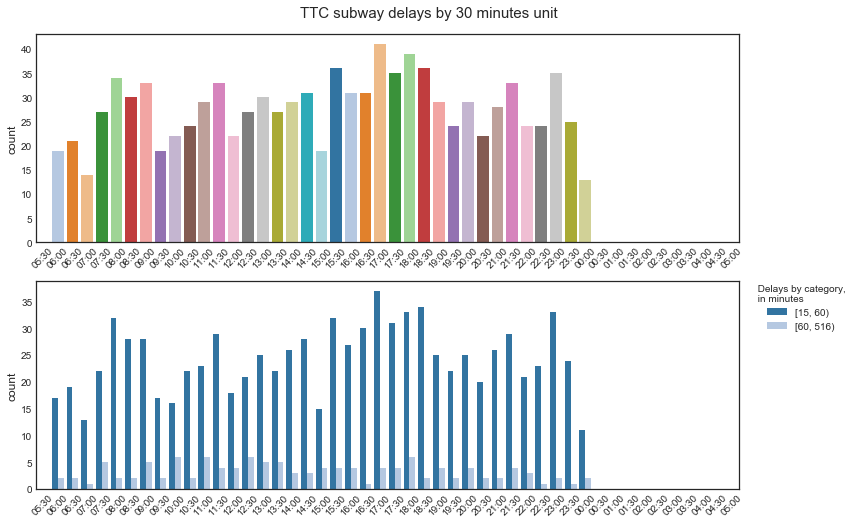

In [36]:
# Plot the counts of time when delay occur by 30 minutes period from 6:00 to 00:00
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,7))

sns.countplot(data['Round_Time_30_min'], data=data_time, order=hours, palette=colors, ax=ax1)
sns.countplot(data['Round_Time_30_min'], data=data_time, order=hours, hue='Delay_Time_Range', palette=colors, ax=ax2)

# Add a title to the figure
fig.suptitle(delays_title_epl + '30 minutes unit' +'\n',verticalalignment='baseline')

# Set a legend
ax2.legend(bbox_to_anchor=(1.01, 1.03), title=title_delays)

# Set ticks
ax1.xaxis.set_tick_params(rotation=45)
ax2.xaxis.set_tick_params(rotation=45)

ax1.set_xlabel('')
ax2.set_xlabel('')

plt.tight_layout()

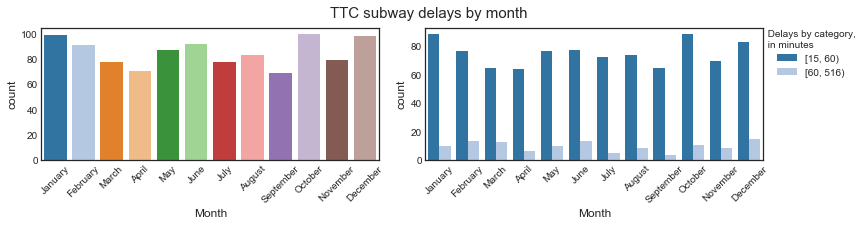

In [37]:

# Plot the counts of observations by month
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
sns.countplot(data['Month'], data=data, palette=colors, ax=ax1)
sns.countplot(data['Month'], data=data, palette=colors, hue='Delay_Time_Range', ax=ax2)

# Add a title to the figure
fig.suptitle(delays_title_epl + 'month',verticalalignment='baseline')

ax1.set_xticklabels(labels=months)
ax2.set_xticklabels(labels=months)

ax1.xaxis.set_tick_params(rotation=45)
ax2.xaxis.set_tick_params(rotation=45)

# Set a legend
ax2.legend(bbox_to_anchor=(1.3, 1.05), title=title_delays)

plt.tight_layout()

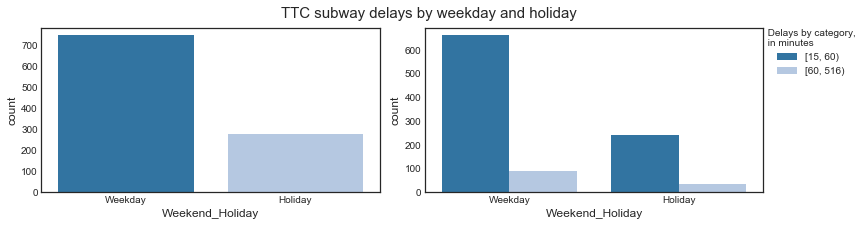

In [38]:
# Plot the counts of observations by weekday and holiday
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
sns.countplot(data['Weekend_Holiday'], data=data, palette=colors, order=[0,1], ax=ax1)
sns.countplot(data['Weekend_Holiday'], data=data, palette=colors, order=[0,1], hue='Delay_Time_Range', ax=ax2)

# Add a title to the figure
fig.suptitle(delays_title_epl + 'weekday and holiday',verticalalignment='baseline')

labels=['Weekday','Holiday']
ax1.set_xticklabels(labels=labels)
ax2.set_xticklabels(labels=labels)
# Set a legend
ax2.legend(bbox_to_anchor=(1.3, 1.05), title=title_delays)

plt.tight_layout()

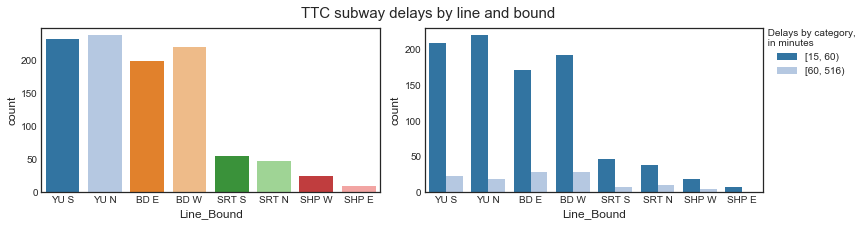

In [39]:
# Plot the counts of observations by line and bound
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
sns.countplot(data['Line_Bound'], data=data, palette=colors, ax=ax1)
sns.countplot(data['Line_Bound'], data=data, palette=colors, hue='Delay_Time_Range', ax=ax2)

# Add a title to the figure
fig.suptitle(delays_title_epl + 'line and bound',verticalalignment='baseline')

# Set a legend
ax2.legend(bbox_to_anchor=(1.3, 1.05), title=title_delays)
plt.tight_layout()

In [40]:
data.columns

Index(['Date', 'Time', 'Day', 'Station', 'Min Delay', 'Bound', 'Line',
       'Reason for delay', 'Delay_Time_Range', 'Month', 'Weekday',
       'Time_Delta', 'Time_Round_30_min', 'Range', 'Row_Index', 'Range_List',
       'Time_DF', '05:30', '06:00', '06:30', '07:00', '07:30', '08:00',
       '08:30', '09:00', '09:30', '10:00', '10:30', '11:00', '11:30', '12:00',
       '12:30', '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00',
       '16:30', '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00',
       '20:30', '21:00', '21:30', '22:00', '22:30', '23:00', '23:30', '00:00',
       '00:30', '01:00', '01:30', '02:00', '02:30', '03:00', '03:30', '04:00',
       '04:30', '05:00', 'Round_Time_30_min', 'Holiday', 'Weekend',
       'Weekend_Holiday', 'Line_Bound'],
      dtype='object')

In [41]:
# Drop columns which were used for feature engineering and calculations
drop_columns = ['Date', 'Time', 'Day', 'Station', 'Min Delay', 'Bound', 'Line','Reason for delay', 'Time_Round_30_min', 
                'Time_Delta', 'Range', 'Row_Index', 'Range_List', 'Time_DF','Round_Time_30_min', 'Weekend','Holiday']

data.drop(drop_columns, axis=1, inplace=True)
data.head()

,Delay_Time_Range,Month,Weekday,05:30,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,05:00,Weekend_Holiday,Line_Bound
0,"[15, 60)",8,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,YU S
1,"[15, 60)",8,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,YU N
2,"[60, 516)",8,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,YU S
3,"[15, 60)",8,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BD E
4,"[60, 516)",8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BD W


In [42]:
# data.columns

In [43]:
# Create a list of time range columns
time_columns = ['05:30', '06:00', '06:30',
       '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00', '10:30',
       '11:00', '11:30', '12:00', '12:30', '13:00', '13:30', '14:00', '14:30',
       '15:00', '15:30', '16:00', '16:30', '17:00', '17:30', '18:00', '18:30',
       '19:00', '19:30', '20:00', '20:30', '21:00', '21:30', '22:00', '22:30',
       '23:00', '23:30', '00:00', '00:30', '01:00', '01:30', '02:00', '02:30',
       '03:00', '03:30', '04:00', '04:30', '05:00']

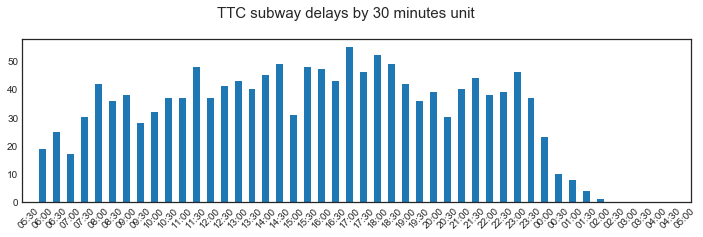

In [44]:
# Plot sum of observations in the time range columns
fig, ax = plt.subplots(figsize=(12,3))
ax = data[time_columns].sum().plot.bar()

# Add a title to the figure
fig.suptitle(delays_title_epl + '30 minutes unit',verticalalignment='baseline')

ax.xaxis.set_tick_params(rotation=45)


In [45]:
# Create a list
drop_null_columns = []
# Loop through columns
for data_column in data.columns:
    # Add time range columns with only 0 values to the list
    if data[data_column].sum()==0:
        drop_null_columns.append(data_column)

print(drop_null_columns)

# Drop empty time range columns 
data.drop(drop_null_columns, axis=1, inplace=True)
data.head()

['05:30', '02:30', '03:00', '03:30', '04:00', '04:30', '05:00']


,Delay_Time_Range,Month,Weekday,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,00:00,00:30,01:00,01:30,02:00,Weekend_Holiday,Line_Bound
0,"[15, 60)",8,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,YU S
1,"[15, 60)",8,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,YU N
2,"[60, 516)",8,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,YU S
3,"[15, 60)",8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BD E
4,"[60, 516)",8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BD W


In [46]:
# Convert categorical variable into dummy/indicator variables
cat_features =['Month', 'Weekday', 'Line_Bound']
data = pd.get_dummies(data, columns=cat_features, drop_first=True)
data.head()

,Delay_Time_Range,06:00,06:30,07:00,07:30,08:00,08:30,09:00,09:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,00:00,00:30,01:00,01:30,02:00,Weekend_Holiday,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Line_Bound_BD W,Line_Bound_SHP E,Line_Bound_SHP W,Line_Bound_SRT N,Line_Bound_SRT S,Line_Bound_YU N,Line_Bound_YU S
0,"[15, 60)",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,"[15, 60)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,"[60, 516)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,"[15, 60)",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,"[60, 516)",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [47]:
print(data.shape)

(1025, 67)

In [48]:
# Save the data to the 'Prepared Data' folder
data.to_excel('3. Prepared Data/ttc_2_ranges_prepared_data.xlsx', index=False)
print("The file '3. Prepared Data/ttc_2_ranges_prepared_data.xlsx' is saved.")